In [1]:
import pandas as pd
import numpy as np
import json

## 导入三元组以及概念上位信息，处理成完整的语义网络

In [12]:
#isA关系加入csv中，为neo4J准备

#df_rel = pd.read_csv('CCFD_triples_isA_added.csv')
#df_entity = pd.read_csv('CCFD_entities_with_tail.csv')



#isA关系和其他关系分开，为大宽表准备

#df_rel_raw = pd.read_csv('00_Raw Data/Wenyue/From_Wenyeu/CCFD_triples.csv')
df_rel_raw = pd.read_csv('00_Raw Data/All concepts and features.csv')
df_concept_info = pd.read_csv('00_Raw Data/CCFD_concept_info.csv')
df_concept_info.head()

In [17]:
# join 三元组及每个entity的属性信息

df_complete = df_rel_raw.join(df_concept_info.set_index('Id'), on='Concept').drop(["Unnamed: 4", "Label", "concept", "superior category", "subcategory", "familiarity", "concretness", "coverage"], axis=1)
df_complete.head()

,Concept,Rel,Feature,Frequency,上级类别,下级类别
0,安全带,可以,可以-保护,27.096774,人造物,工具
1,安全带,是,是-带子,22.258065,人造物,工具
2,安全带,其他,其他-车,17.419355,人造物,工具
3,安全带,是,是-安保的,16.451613,人造物,工具
4,安全带,可以,可以-保护人,15.483871,人造物,工具


In [33]:
# df_complete.to_csv('01_Processed Data/Complete-Data.csv',index=False)
# df_complete = pd.read_csv('01_Processed Data/Complete-Data.csv')

## 模拟患者语义网络

In [20]:
## 提示词

cues_0 = ['耳朵','手掌', '脚后跟','肩膀','牙齿','鼻子']
cues_1 = ['鸽子','麻雀', '燕子','天鹅','喜鹊','猫头鹰']
cues_2 = ['猴子','狮子', '兔子','老虎','老鼠','奶牛']
cues_3 = ['苹果','香蕉', '葡萄','甘蔗','柑橘','西瓜']
cues_4 = ['萝卜','土豆', '白菜','黄瓜','韭菜','茄子']
cues_5 = ['直升机','火车', '帆船','卡车','轿车','摩托车']
cues_6 = ['茅草屋','人行天桥', '车库','立交桥','高速公路','喷泉']
cues_7 = ['衬衫','毛衣', '夹克','袜子','围巾','裤子']
cues_8 = ['沙发','椅子', '餐桌','书柜','马桶','冰箱']
cues_9 = ['扫帚','雨伞', '剪刀','纱布','拐杖','筷子']

cues = cues_0 + cues_1 + cues_2 + cues_3 + cues_4 + cues_5 + cues_6 + cues_7 + cues_8 + cues_9

In [24]:
## 选择提示词相关的所有语义特征，作为个人语义网络数据

#检验提示词是否在数据库中
#len(df_rel[df_rel['head']=="脚跟"])

for cue in cues:
    if len(df_complete[df_complete['Concept']==cue]) == 0:
        print(cue)
    else:
        print(df_complete[df_complete['Concept']==cue])
        
df_complete_individual = df_complete[df_complete['Concept'].isin(cues)]

      Concept Rel  Feature  Frequency  上级类别  下级类别
11058      耳朵  可以     可以-听  24.193548  身体部位  身体部位
11059      耳朵   是     是-器官  23.225806  身体部位  身体部位
11060      耳朵  需要    需要-保护  22.258065  身体部位  身体部位
11061      耳朵   有     有-耳廓  11.612903  身体部位  身体部位
11062      耳朵  需要    需要-清洗   9.677419  身体部位  身体部位
11063      耳朵  其他     其他-人   8.709677  身体部位  身体部位
11064      耳朵   有     有-耳垂   8.709677  身体部位  身体部位
11065      耳朵   有     有-耳蜗   7.741935  身体部位  身体部位
11066      耳朵   是   是-身体部位   5.806452  身体部位  身体部位
11067      耳朵   像      像-3   4.838710  身体部位  身体部位
11068      耳朵   有     有-耳膜   4.838710  身体部位  身体部位
11069      耳朵  可以   可以-戴耳环   3.870968  身体部位  身体部位
11070      耳朵   是     是-五官   3.870968  身体部位  身体部位
11071      耳朵   有     有-耳道   3.870968  身体部位  身体部位
11072      耳朵  可以   可以-打耳洞   2.903226  身体部位  身体部位
11073      耳朵  其他    其他-动物   2.903226  身体部位  身体部位
11074      耳朵   是     是-软的   2.903226  身体部位  身体部位
11075      耳朵   是    是-重要的   2.903226  身体部位  身体部位
11076      耳朵   像     像-蜗牛   2.903226  身体部位  身体部位


573      白菜   有   有-多种种类   2.142857   植物   蔬菜
      Concept Rel Feature  Frequency 上级类别 下级类别
19144      黄瓜   是    是-食物       28.0   植物   蔬菜
19145      黄瓜   是    是-蔬菜       23.0   植物   蔬菜
19146      黄瓜   是   是-绿色的       19.0   植物   蔬菜
19147      黄瓜   像    像-丝瓜       13.0   植物   蔬菜
19148      黄瓜  需要    需要-水       13.0   植物   蔬菜
19149      黄瓜   有     有-刺       12.0   植物   蔬菜
19150      黄瓜   是    是-长的       11.0   植物   蔬菜
19151      黄瓜  需要   需要-种植       11.0   植物   蔬菜
19152      黄瓜  可以    可以-炒       10.0   植物   蔬菜
19153      黄瓜   是    是-植物       10.0   植物   蔬菜
19154      黄瓜  需要   需要-清洗        9.0   植物   蔬菜
19155      黄瓜  需要    需要-土        9.0   植物   蔬菜
19156      黄瓜  需要   需要-阳光        9.0   植物   蔬菜
19157      黄瓜   有     有-皮        9.0   植物   蔬菜
19158      黄瓜   有     有-籽        9.0   植物   蔬菜
19159      黄瓜  可以   可以-凉拌        7.0   植物   蔬菜
19160      黄瓜  可以   可以-生吃        7.0   植物   蔬菜
19161      黄瓜   是   是-条状的        7.0   植物   蔬菜
19162      黄瓜  需要   需要-采摘        7.0   植物   蔬菜
19163      黄瓜 

35025      扫帚   有    有-杆子        2.0  人造物   工具
      Concept Rel  Feature  Frequency 上级类别 下级类别
48412      雨伞  可以    可以-挡雨       18.0  人造物   工具
48413      雨伞   像     像-蘑菇       15.0  人造物   工具
48414      雨伞   是     是-工具       13.0  人造物   工具
48415      雨伞   有     有-伞柄       12.0  人造物   工具
48416      雨伞  需要    需要-制造        9.0  人造物   工具
48417      雨伞   有   有-多种颜色        7.0  人造物   工具
48418      雨伞  可以    可以-防水        6.0  人造物   工具
48419      雨伞   有     有-伞面        6.0  人造物   工具
48420      雨伞  可以    可以-打开        5.0  人造物   工具
48421      雨伞  可以    可以-买卖        5.0  人造物   工具
48422      雨伞   是   是-生活用品        5.0  人造物   工具
48423      雨伞   是     是-雨具        5.0  人造物   工具
48424      雨伞  需要    需要-撑开        5.0  人造物   工具
48425      雨伞   有     有-把手        5.0  人造物   工具
48426      雨伞   有   有-多种样式        5.0  人造物   工具
48427      雨伞   有     有-支架        5.0  人造物   工具
48428      雨伞   是     是-圆形        4.0  人造物   工具
48429      雨伞   有   有-多种型号        4.0  人造物   工具
48430      雨伞   有     有-伞布        4.0  人造

In [27]:
## 随机采样，模拟受损的个人语义网络

np.random.seed(10)
remove_n = round(len(df_complete_individual)*0.3)
drop_indices = np.random.choice(df_complete_individual.index, remove_n, replace=False)
len(drop_indices)


#为neo4j数据库删除部分数据
#df_impair_individual = df_complete_individual.drop(drop_indices)

#为大宽表做标记
df_impair_individual = df_complete_individual.copy()
df_impair_individual['impair'] = 0
for row in df_impair_individual.iterrows():
    if row[0] in drop_indices:
        df_impair_individual.loc[row[0],'impair'] = 1
    else:
        pass
    
    
df_impair_individual[df_impair_individual['impair']==1]

#为neo4j存储
#df_impair_individual.to_csv('CCFD_60_words_0.7_sampleRate.csv',index=False)

#为大宽表存储
df_impair_individual.to_csv('01_Processed Data/PWA_Minor.csv', index=False)
# df_impair_individual = pd.read_csv('01_Processed Data/PWA_Minor.csv')

## 从完整网络中抽取关联网络

In [27]:
## 抽取关联网络
def Extract_Association_Network(df, entity_col, association_col, strength_thres):
    Source = []
    Target = []
    Strength = []
    
    entities = list(df[entity_col].unique())
    
    for i in range(len(entities)):
        for j in range(1, (len(entities) - i)):
            listA = list(df[df[entity_col]==entities[i]][association_col].unique())
            listB = list(df[df[entity_col]==entities[i+j]][association_col].unique())
            strength = len(set(listA)&set(listB))
            if strength > strength_thres:
                #print(features[i],features[i+j],features)
                Source.append(entities[i])
                Target.append(entities[i+j])
                Strength.append(strength)
                
    data_AssociationNetwork = {'Source': Source, 'Target': Target, 'Strength': Strength}
    df_AssociationNetwork = pd.DataFrame(data = data_AssociationNetwork)
    return df_AssociationNetwork

In [8]:
df_impair_individual_concept_network = Extract_Association_Network(df_impair_individual, 'Concept', 'Feature', 5)
df_impair_individual_concept_network.head()

,Source,Target,Strength
0,白菜,甘蔗,14
1,白菜,柑橘,13
2,白菜,鸽子,6
3,白菜,黄瓜,19
4,白菜,韭菜,15


In [28]:
test_2 = Extract_Association_Network(df_impair_individual, 'Feature', 'Concept', 5)
test_2.head()

,Source,Target,Strength
0,是-蔬菜,是-植物,6
1,是-蔬菜,需要-水,6
2,是-蔬菜,需要-阳光,6
3,是-蔬菜,是-食物,6
4,是-蔬菜,需要-空气,6


In [29]:
test_2.to_csv('01_Processed Data/SemanticFeature_Link_PWA-Minor.csv')

In [88]:
df.to_csv('01_Processed Data/SemanticFeature_Link.csv',index=False)
#df_ConceptNetwork.to_csv('02_Graph Data/Concept_Link.csv',index=False)

## Node_Link CSV to NodeTrix Json

In [150]:
# Nodetrix json format

# "nodes":[
#     {"name":"Myriel","group":1},
#         ...]
# "links":[
#     {"source":1,"target":0,"value":1},
#         ...]

In [35]:
# 为了适应NodeTrix/G6等不同库的数据格式需求，设置两个参数
# link_object_name: "links" / "edges" 
# node_content_mode: "index" / "name"

def Node_Link_CSV2Json(df_link, df_node, node_name_col, node_group_col, link_object_name, node_content_mode):
    
    data = {
        "nodes": [],
        link_object_name: []
    }
    groups = []

    nodes = list(set(list(df_link.Source)+list(df_link.Target)))
    for node in nodes: 
        df_selected_node = df_node[df_node[node_name_col]==node]
        group = list(df_selected_node[node_group_col])[0]
        if group not in groups:
            groups.append(group)
        new_node = {        
            "id":list(df_selected_node[node_name_col])[0],
            "group":groups.index(group)
        } 
        if new_node not in data['nodes']:
            data['nodes'].append(new_node)


    for row in df_link.iterrows():
        
        if node_content_mode == "index":
            new_link = {
                "source":nodes.index(row[1]['Source']),
                "target":nodes.index(row[1]['Target']),
                "value":int(row[1]['Strength'])
            }
        elif node_content_mode == "name":
            new_link = {
                "source":row[1]['Source'],
                "target":row[1]['Target'],
                "value":int(row[1]['Strength'])
            }
            
        if new_link not in data[link_object_name]:
            data[link_object_name].append(new_link)
            
    print("nodes: "+str(len(data['nodes'])))
    print("links: "+str(len(data[link_object_name])))
            
    return data

<AxesSubplot:>

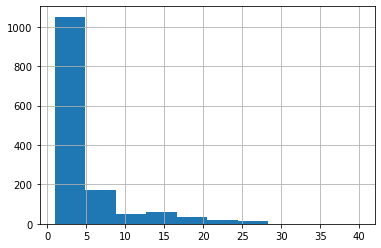

In [147]:
df_link = df_impair_individual_concept_network
df_link['Strength'].hist()

In [33]:
df_node = pd.read_csv('00_Raw Data/All concepts and features.csv')
df_node.head()

,Concept,Rel,Feature,Frequency,Unnamed: 4
0,安全带,可以,可以-保护,27.096774,NaN
1,安全带,是,是-带子,22.258065,NaN
2,安全带,其他,其他-车,17.419355,NaN
3,安全带,是,是-安保的,16.451613,NaN
4,安全带,可以,可以-保护人,15.483871,NaN


In [22]:
len(df_node)

1410

In [25]:
df_concept_network = pd.read_csv('02_Graph/Concept_Link.csv')
df_concept_network.head()

,Source,Target,Strength
0,安全带,安全帽,7
1,安全带,按键,5
2,安全带,按摩器,2
3,安全带,按钮,6
4,安全带,八哥,1


In [37]:
data = Node_Link_CSV2Json(df_concept_network,df_node,"Label","下级类别", "edges", "name")
%%time

KeyError: 'Label'

In [38]:
data = Node_Link_CSV2Json(test_2,df_node,"Feature","Rel", "edges", "name")

nodes: 82
links: 577


In [39]:
with open("04_G6/CCFD_G6_Feature_PWA-Minor.json", "w") as f: 
    json.dump(data, f, ensure_ascii=False)